# Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [3]:
import torch

In [4]:
print(torch.cuda.is_available())

True


In [5]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import anndata as ad
import scanpy as sc
import scanpy as sc
import torch
import scipy.spatial
import matplotlib
import matplotlib.patches as mpatches
import string


In [6]:
from omegaconf import OmegaConf
import pytorch_lightning as pl

In [7]:
DATA_PATH = '/braid/havivd/scgen/kang_scimilarity_v4_with_concepts.h5ad'
OBSM_KEY = 'X_pca'
Z_SCORE = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 0

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:

import itertools
from collections import defaultdict

# DATA LOADING AND PREPARATION

In [9]:
def split_data(adata, hold_out_label, mod_label, label_key = 'L2_stim'):
    """
    Splits data into train, intervention, and ground truth sets.

    - Ground Truth: All cells with the `hold_out_label`.
    - Intervention: All cells with the `mod_label`.
    - Train: All remaining cells.
    """
    print("Splitting data with simplified logic...")
    labels = adata.obs[label_key]

    # Define the three disjoint sets based on their labels
    is_test = (labels == hold_out_label)
    is_inter = (labels == mod_label)
    is_train = ~is_test

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'intervention'
    adata.obs['ident'] = ident_vec
    

    return adata, adata_train, adata_test, adata_inter



# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [10]:
def train_cbgm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca', orthogonality_hp = 0.5):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    # --- MODIFICATION END ---

    torch.set_flush_denormal(True)

    config = OmegaConf.create(dict(
        has_cbm=True, 
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_unknown=128, 
        concepts_hp=0.1, 
        orthogonality_hp=orthogonality_hp, 
        use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def pred_cbgm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    if(obsm_key != 'X'):
        x_intervene_on = torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [11]:
def get_learned_concepts(scCBGM_model, adata_full, obsm_key = 'X_pca'):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")

    if(obsm_key != 'X'):
        all_x = torch.tensor(adata_full.obsm[obsm_key], dtype=torch.float32).to('cuda')
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32).to('cuda')

    with torch.no_grad():
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()

    adata_full.obsm['scCBGM_concepts'] = np.concatenate([adata_full.obsm['scCBGM_concepts_known'], adata_full.obsm['scCBGM_concepts_unknown']], axis=1)
    return adata_full

def train_cb_fm(adata_train, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Bottleneck Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_laye1rs=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_cb_fm(model, adata_inter, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca', edit = True):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")

    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
    
    c_known_inter = adata_inter.obsm[concept_key + '_known'].astype(np.float32)
    c_unknown_inter = adata_inter.obsm[concept_key + '_unknown'].astype(np.float32)
    
    inter_concepts_known = c_known_inter.copy()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    


    init_concepts = np.concatenate([c_known_inter, c_unknown_inter], axis=1)
    edit_concepts = np.concatenate([inter_concepts_known, c_unknown_inter], axis=1)

    # init_concepts = adata_inter.obsm[concept_key].astype(np.float32)
    # edit_concepts = init_concepts.copy()
    # edit_concepts[:, -1] = 1 # Set stim concept to 1

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
        
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata



## Method 3: Flow Matching with Raw Concepts 

In [12]:
def train_raw_fm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Conditonal Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].to_numpy().shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_raw_fm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca', edit = False):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with Raw Flow Matching(learned)...")
    init_concepts = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)   
    edit_concepts = init_concepts.copy()
    edit_concepts[:, -1] = 1 # Set stim concept to 1
    
    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata




# Method 4: CB VAE FM

In [13]:
def train_cb_fm_vae(adata_train, concept_key = 'concepts', obsm_key = 'X_pca', kl_hp = 0.1, concepts_hp = 0.1, orthogonality_hp = 0.1):
    """Trains and returns the scCBGM model."""
    print("Training Concept Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].to_numpy().shape[1],
        n_unknown=128,
        n_layers=4,
        dropout=0.1,
        p_uncond=0.0,
        skip_connection = True,
        unknown_activation = 'relu',
        kl_hp = kl_hp,
        concepts_hp=concepts_hp, 
        orthogonality_hp=orthogonality_hp,
        data_prior = True,
        flow_hp = 1.0)

    fm_model = clab.models.concept_fm.Concept_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model


def pred_cb_fm_vae(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca', edit = True):
    """Performs intervention using a trained CB_FM_VAE model."""
    print("Performing intervention with CB_FM_VAE...")
    if(obsm_key != 'X'):
        x_intervene_on =  torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)
    c_intervene_on = torch.tensor(c_intervene_on, dtype=torch.float32)
    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)

    inter_concepts = c_intervene_on.clone()
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    if(edit):
        print("Editing with t_edit=0.0, noise_add=0.0")
        with torch.no_grad():
            z = model.encode(x_intervene_on.to('cuda'))
            unknown = model.cb_unk_layers(z)

            c_original = torch.cat([c_intervene_on.to('cuda'), unknown], dim=1)
            c_edit = torch.cat([inter_concepts.to('cuda'), unknown], dim=1)

            inter_preds = model.edit(
                x = x_intervene_on.to('cuda'),
                c = c_original,
                c_prime = c_edit,
                t_edit = 0.0,
            noise_add = 0.0)
    else:
        with torch.no_grad():
            inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds.cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


# Method 5: cVAE

In [14]:
def train_cvae(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the scCVAE model."""
    print("Training scCVAE model...")

    # --- Data Sourcing Logic (Unchanged) ---
    # Conditionally set the data source and input dimension
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    # --- End of Logic ---

    torch.set_flush_denormal(True)

    # --- Config (MODIFIED for scCVAE) ---
    # Removed: has_cbm, n_unknown, concepts_hp, orthogonality_hp, use_soft_concepts
    # Kept: lr, hidden_dim, n_layers, beta, input_dim, latent_dim, n_concepts
    config = OmegaConf.create(dict(
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1]
    ))
    
    # --- Model Instantiation (MODIFIED for scCVAE) ---
    model = clab.models.scCVAE(config)

    # --- Training Loop (Unchanged) ---
    # The train_loop signature in scCVAE.py is the same
    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def pred_cvae(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs counterfactual intervention using a trained scCVAE model."""
    print("Performing intervention with scCVAE...")
    
    # --- Data Sourcing Logic (Unchanged) ---
    if(obsm_key != 'X'):
        x_intervene_on = torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    
    # This is the *original* set of concepts to encode with
    c_intervene_on_numpy = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)
    concepts_enc = torch.tensor(c_intervene_on_numpy, dtype=torch.float32)


    # --- Intervention Definition (Unchanged) ---
    # Define the intervention by creating new concept values
    # We still create the 'mask' locally to help build the new concept tensor
    mask = torch.zeros(c_intervene_on_numpy.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    # This is the *new* set of concepts to decode with
    concepts_dec = torch.tensor(c_intervene_on_numpy, dtype=torch.float32)
    concepts_dec[:, -1] = 1 # Set stim concept to 1

    # --- Model Intervention (MODIFIED for scCVAE) ---
    with torch.no_grad():
        # Use the new intervene(x, concepts_enc, concepts_dec) signature
        inter_preds = model.intervene(
            x_intervene_on.to('cuda'), 
            concepts_enc=concepts_enc.to('cuda'), 
            concepts_dec=concepts_dec.to('cuda')
        )
    
    # --- Output Processing (Unchanged) ---
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata

# Method 6: cVAE - FM

In [23]:
def get_cvae_latents(scCVAE_model, adata_full, concept_key = 'concepts', obsm_key = 'X_pca'):
    """
    Uses a trained scCVAE to generate its latent representation ('mu')
    for all data, conditioned on the true concepts.
    
    It saves the latent 'mu' and a concatenation of 'mu' and the
    true concepts into adata_full.obsm.
    """
    print("Generating latents from scCVAE...")
    scCVAE_model.to('cuda') # Ensure model is on the correct device

    # --- 1. Get Input Data 'x' ---
    if(obsm_key != 'X'):
        all_x = torch.tensor(adata_full.obsm[obsm_key], dtype=torch.float32).to('cuda')
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32).to('cuda')

    # --- 2. Get Conditional Data 'concepts' ---
    # The CVAE encoder requires the concepts as an input condition
    all_concepts_numpy = adata_full.obsm[concept_key].to_numpy().astype(np.float32)
    all_concepts = torch.tensor(all_concepts_numpy, dtype=torch.float32).to('cuda')

    # --- 3. Get Latent Variable 'mu' ---
    with torch.no_grad():
        # Encode x *conditioned on* the true concepts
        enc_dict = scCVAE_model.encode(all_x, all_concepts)
        
        # This is the CVAE latent representation
        latent_mu = enc_dict['mu'].cpu().numpy()

    # --- 4. Save Outputs to AnnData ---
    adata_full.obsm['scCVAE_latent'] = latent_mu
    
    # Per request: save the latent concatenated with the true concepts
    adata_full.obsm['scCVAE_latent_and_concepts'] = np.concatenate(
        [latent_mu, all_concepts_numpy], axis=1
    )
    
    print("Saved 'scCVAE_latent' and 'scCVAE_latent_and_concepts' to adata.obsm")
    return adata_full

def train_cvae_fm(adata_train, concept_key = 'scCVAE_latent_and_concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Bottleneck Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_laye1rs=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_cvae_fm(model, adata_inter, concept_key = 'scCVAE_latent_and_concepts', obsm_key = 'X_pca', edit = True):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")

    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
    
    init_concepts = adata_inter.obsm[concept_key].astype(np.float32)
    edit_concepts = init_concepts.copy()
    edit_concepts[:, -1] = 1 # Set stim concept to 1


    # init_concepts = adata_inter.obsm[concept_key].astype(np.float32)
    # edit_concepts = init_concepts.copy()
    # edit_concepts[:, -1] = 1 # Set stim concept to 1

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
        
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata

# Main

## Proccesing

In [15]:
import sklearn.decomposition


print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)

adata.obs['L2_stim'] = [l1_ctype + '_' + stim for l1_ctype, stim in zip(adata.obs['cell_types_L2'], adata.obs['stim'])]

Loading and preprocessing data...


# Run Benchmarking

In [16]:
df_original = pd.read_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results.csv")

In [17]:
cell_labels =  list(set(adata.obs['cell_types_L2']))

In [18]:
benchmark_results = defaultdict(lambda: defaultdict(list))

In [ ]:
# --- Results Storage Initialization ---




## Main Benchmark Loop
# =================================================================
# In this loop, we evaluate all models with their default parameters
# across all cell types to get a baseline performance comparison.
# =================================================================

print("--- Starting Main Benchmark Across All Labels ---")
for label in cell_labels:

    hold_out_label = label + '_stim'
    mod_label = label + '_ctrl'
    
    _, adata_train, adata_test, adata_inter = split_data(
        adata, hold_out_label, mod_label, label_key = 'L2_stim'
    )

    print(f"\n--- Processing Label: {label} ---")
    print(f"Train set: {len(adata_train)} cells, Test set: {len(adata_test)} cells")

    # PCA Transformation
    adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X) # type: ignore
    for x_data in [adata, adata_train, adata_test, adata_inter]:
        x_data.uns['pc_transform'] = adata.uns['pc_transform']
        x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X) # type: ignore

    # --- Train All Models ---


    print("Training and Evaluating CBGM")

    # cbgm_model = train_cbgm(adata_train.copy())
    # pred_adata_cbgm = pred_cbgm(cbgm_model, adata_inter.copy())

    # print("Training and Evaluating CBGM, no ortho loss")

    # cbgm_model_no_ortho = train_cbgm(adata_train.copy(), orthogonality_hp = 0.0)
    # pred_adata_cbgm_no_ortho = pred_cbgm(cbgm_model_no_ortho, adata_inter.copy())

    # print("Training and Evaluating FM")

    # adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
    # adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
    # adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

    # adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
    # adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

    # adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
    # adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

    
    # cb_fm_model = train_cb_fm(adata_train.copy())
    # pred_adata_fm_edit = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = True)
    # pred_adata_fm_guid = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = False)

    # print("Training and Evaluating Raw FM")
    
    # fm_raw_model = train_raw_fm(adata_train.copy())
    # pred_adata_raw_fm_edit = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = True)
    # pred_adata_raw_fm_guid = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = False)

    # print("Training and Evaluating Concept Flow VAE")

    # # Train VAE model with default hyperparameters
    # cb_fm_vae_model = train_cb_fm_vae(adata_train.copy(), kl_hp = 1.0, concepts_hp = 1.0, orthogonality_hp = 1.0)
    # pred_adata_cb_fm_vae = pred_cb_fm_vae(cb_fm_vae_model, adata_inter.copy(), edit = False)

    print("Training and Evaluating cVAE")

    # Train VAE model with default hyperparameters
    cvae_model = train_cvae(adata_train.copy())
    pred_adata_cvae_model = pred_cvae(cvae_model, adata_inter.copy())

    print("Training and Evaluating cVAE - FM")

    adata_with_cvae_latents = get_cvae_latents(cvae_model, adata.copy())

    adata_train.obsm['scCVAE_latent_and_concepts'] = adata_with_cvae_latents[adata_train.obs.index].obsm['scCVAE_latent_and_concepts']
    adata_inter.obsm['scCVAE_latent_and_concepts'] = adata_with_cvae_latents[adata_inter.obs.index].obsm['scCVAE_latent_and_concepts']

    cvae_fm_model = train_cvae_fm(adata_train.copy())

    pred_adata_cvae_fm_edit = pred_cvae_fm(cvae_fm_model, adata_inter.copy(), edit = True)
    pred_adata_cvae_fm_guid = pred_cvae_fm(cvae_fm_model, adata_inter.copy(), edit = False)





    
    # --- Benchmark All Models for this Label ---
    pre_computed_mmd_train = -1
    # all_models = [pred_adata_cbgm, pred_adata_fm_edit, pred_adata_fm_guid, pred_adata_raw_fm_edit,  pred_adata_raw_fm_guid, pred_adata_cb_fm_vae]
    # all_names = ['scCBGM', 'CB-FM (edit)', 'CB-FM (guided)', 'Raw-FM (edit)', 'Raw-FM (guided)', 'CB-FM (VAE)']

    all_models = [pred_adata_cvae_model, pred_adata_cvae_fm_edit, pred_adata_cvae_fm_guid]
    all_names = ['cVAE', 'cVAE-FM (edit)', 'cVAE-FM (guided)']


    for pred_adata, name in zip(all_models, all_names):
        # Check if the baseline MMD has been computed for this label yet
        if pre_computed_mmd_train == -1:
            # First run: compute everything and store the baseline MMD
            evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
                x_train=adata_train.obsm[OBSM_KEY], 
                x_ivn=pred_adata.obsm[OBSM_KEY], # type: ignore
                x_target=adata_test.obsm[OBSM_KEY],
                labels_train=adata_train.obs['L1_stim'].values
            )
            mmd_ratio = evaluation_output['mmd_ratio']
            pre_computed_mmd_train = evaluation_output['pre_computed_mmd_train']
        else:
            # Subsequent runs: provide the pre-computed baseline MMD to save time
            evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
                x_train=adata_train.obsm[OBSM_KEY], 
                x_ivn=pred_adata.obsm[OBSM_KEY],  # type: ignore
                x_target=adata_test.obsm[OBSM_KEY],
                labels_train=adata_train.obs['L1_stim'].values,
                pre_computed_mmd_train=pre_computed_mmd_train
            )
            mmd_ratio = evaluation_output['mmd_ratio']

        # Now, calculate true MMD and store results
        true_mmd = mmd_ratio * pre_computed_mmd_train
        
        benchmark_results[name]['mmd_ratio'].append(mmd_ratio)
        benchmark_results[name]['true_mmd'].append(true_mmd)
        
        print(f"  > {name}: mmd_ratio={mmd_ratio:.4f}, true_mmd={true_mmd:.4f}")

    print(df_original[df_original['label'] == label])
        # print(df[df['label']==label])
print("\n--- Main Benchmark Finished ---")


--- Starting Main Benchmark Across All Labels ---
Splitting data with simplified logic...



--- Processing Label: Dendritic cells_0 ---
Train set: 23928 cells, Test set: 126 cells
Training and Evaluating CBGM
Training and Evaluating cVAE
Training scCVAE model...
Starting CVAE training on cuda for 200 epochs...


Training Progress: 100%|█████████████████| 200/200 [02:19<00:00,  1.43it/s, avg_loss=4.845e-03, rec_loss=4.792e-03, kl_loss=5.312e+00, lr=1.64990e-04]


Training finished.
Performing intervention with scCVAE...
Training and Evaluating cVAE - FM
Generating latents from scCVAE...
Saved 'scCVAE_latent' and 'scCVAE_latent_and_concepts' to adata.obsm


NameError: name 'train_cvae_fm' is not defined

Generating latents from scCVAE...
Saved 'scCVAE_latent' and 'scCVAE_latent_and_concepts' to adata.obsm
Training Concept Bottleneck Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|██████| 200/200 [01:50<00:00,  1.81it/s, avg_loss=3.199e-01, lr=1.64990e-04]


Performing intervention with CB-FM (learned)...
Editing from t=1.0 back to t=0.00, then forward with new condition.


Performing intervention with CB-FM (learned)...
Decoding with 1000 steps and CFG scale w=1.0


In [51]:
# df.to_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results.csv", index=False)

long_form_data = []
for model_name, metrics in benchmark_results.items():
    # Ensure the number of scores matches the number of labe
        
    for i, label in enumerate(cell_labels[:len(metrics['true_mmd'])]):
        long_form_data.append({
            'label': label,
            'model': model_name,
            'true_mmd': metrics['true_mmd'][i],
            'mmd_ratio': metrics['mmd_ratio'][i]
        })

df = pd.DataFrame(long_form_data)




In [52]:
df

,label,model,true_mmd,mmd_ratio
0,FCGR3A+ Monocytes_1,CB-FM (VAE),0.060277,4.375122
1,CD8 T cells_1,CB-FM (VAE),0.021026,0.323810
2,NK cells_0,CB-FM (VAE),0.031390,0.185118
3,B cells_0,CB-FM (VAE),0.022251,0.138983
4,B cells_1,CB-FM (VAE),0.011758,0.076384
5,Dendritic cells_1,CB-FM (VAE),0.069258,0.444160
6,Dendritic cells_0,CB-FM (VAE),0.088866,0.243140
7,CD4 T cells_2,CB-FM (VAE),0.010921,0.056855
8,CD14+ Monocytes_1,CB-FM (VAE),0.063144,0.764093
9,CD4 T cells_1,CB-FM (VAE),0.013996,0.252997


To load my results, uncomment this:

In [53]:
df_original = pd.read_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results.csv")

In [54]:
#df_original['model'] = df_original['model'].replace('CB-FM (VAE)', 'CB-FM (VAE), no prior')
df_original = df_original[df_original['model'] != 'CB-FM (VAE)']

In [56]:
df_original

,label,model,true_mmd,mmd_ratio
0,CD8 T cells_1,scCBGM,0.018300,0.282218
1,B cells_0,scCBGM,0.036183,0.226012
2,CD4 T cells_1,scCBGM,0.014859,0.268587
3,Dendritic cells_1,scCBGM,0.053406,0.341126
4,FCGR3A+ Monocytes_1,scCBGM,0.091187,6.586290
...,...,...,...,...
65,CD14+ Monocytes_0,Raw-FM (guided),0.072337,1.326542
66,FCGR3A+ Monocytes_0,Raw-FM (guided),0.154389,0.678239
67,B cells_1,Raw-FM (guided),0.150442,0.980938
68,CD4 T cells_0,Raw-FM (guided),0.086615,0.867054


In [57]:
# df_original = df_original[df_original['model'] != 'CB-FM (VAE)']
df = pd.concat([df, df_original], axis=0).reset_index(drop=True)

In [58]:
df.pivot(index='label', columns='model', values='true_mmd').idxmin(axis=1).value_counts()

CB-FM (VAE)       7
CB-FM (edit)      4
Raw-FM (edit)     2
CB-FM (guided)    1
Name: count, dtype: int64

In [59]:
# df.to_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results_with_unortho.csv", index=False)

/tmp/ipykernel_2427787/315618988.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)


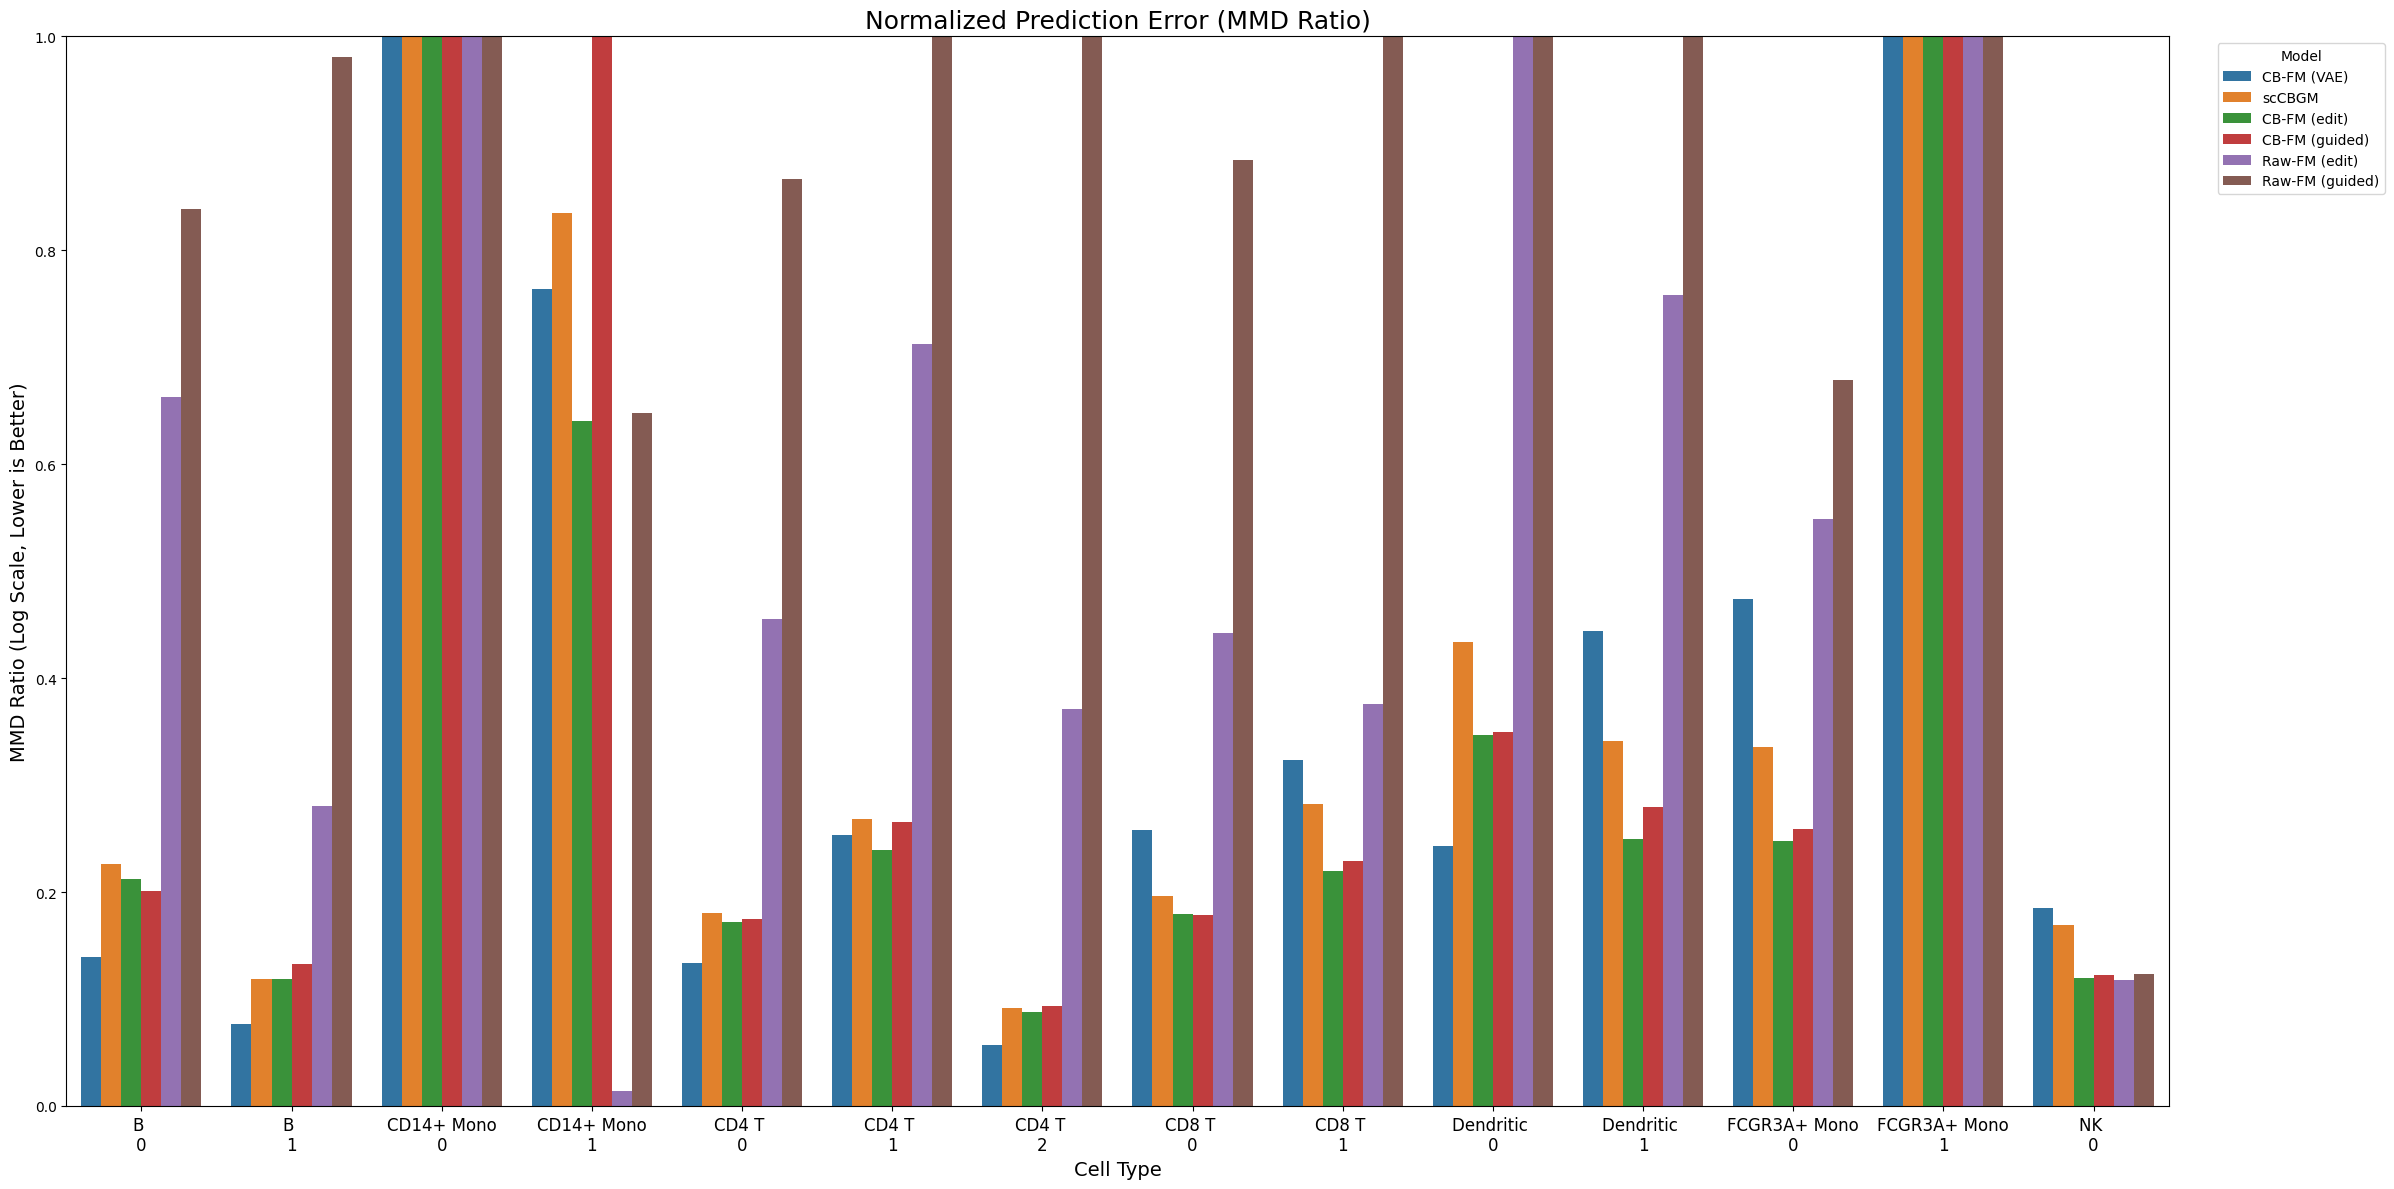

In [61]:



# --- 2. Create Plots ---
fig, ax = plt.subplots(1, 1, figsize=(24, 12)) # Adjusted figsize for a single plot

sorted_labels = sorted(list(set(cell_labels)))

# --- Plot MMD Ratio, ensuring the x-axis is sorted ---
sns.barplot(data=df, x='label', y='mmd_ratio', hue='model', ax=ax, order=sorted_labels)

# --- SET Y-AXIS TO LOG SCALE ---
# ax.set_yscale('log')
# set y lim to 0.1 to 1
ax.set_ylim(0.0, 1)

ax.set_ylabel('MMD Ratio (Log Scale, Lower is Better)', fontsize=14)
ax.set_xlabel('Cell Type', fontsize=14)
ax.set_title('Normalized Prediction Error (MMD Ratio)', fontsize=18)

# Format x-tick labels to be on two lines based on the sorted list
new_labels = [label.replace('_', '\n') for label in sorted_labels]
new_labels = [label.replace('Monocytes', 'Mono') for label in new_labels]
new_labels = [label.replace('cells', '') for label in new_labels]
ax.set_xticklabels(new_labels, fontsize=12)

ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust layout to make space for the external legend and the main title
plt.tight_layout()
plt.show()

# Make Figures

In [19]:
adata.obsm['sample_concepts'] = adata.obsm['concepts'][['stim']]

In [ ]:
hold_out_label = 'CD4 T cells_0' + '_stim'
mod_label = 'CD4 T cells_0' + '_ctrl'

adata, adata_train, adata_test, adata_inter = split_data(
    adata, hold_out_label, mod_label, label_key = 'L2_stim'
)

print(f"\n--- Processing Label: {hold_out_label} ---")
print(f"Train set: {len(adata_train)} cells, Test set: {len(adata_test)} cells")

# PCA Transformation
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X)
for x_data in [adata, adata_train, adata_test, adata_inter]:
    x_data.uns['pc_transform'] = adata.uns['pc_transform']
    x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)

# --- Train All Models ---

print("Training and Evaluating CBGM")

cbgm_model = train_cbgm(adata_train.copy())

print("Training and Evaluating FM")

adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']


cb_fm_model = train_cb_fm(adata_train.copy())

print("Training and Evaluating Raw FM")

fm_raw_model = train_raw_fm(adata_train.copy(), concept_key = 'sample_concepts')

In [23]:
pred_adata_cbgm = pred_cbgm(cbgm_model, adata_inter.copy())

pred_adata_fm_edit = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = True)
pred_adata_fm_guid = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = False)

pred_adata_raw_fm_edit = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = True, concept_key = 'sample_concepts')
pred_adata_raw_fm_guid = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = False, concept_key = 'sample_concepts')

In [ ]:
pre_computed_mmd_train = -1
all_models = [pred_adata_cbgm, pred_adata_fm_edit, pred_adata_fm_guid, pred_adata_raw_fm_edit,  pred_adata_raw_fm_guid]
all_names = ['scCBGM', 'CB-FM (edit)', 'CB-FM (guided)', 'Raw-FM (edit)', 'Raw-FM (guided)']


scores ={}

for pred_adata, name in zip(all_models, all_names):
    # Check if the baseline MMD has been computed for this label yet
    if pre_computed_mmd_train == -1:
        # First run: compute everything and store the baseline MMD
        evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
            x_train=adata_train.obsm[OBSM_KEY], 
            x_ivn=pred_adata.obsm[OBSM_KEY], 
            x_target=adata_test.obsm[OBSM_KEY],
            labels_train=adata_train.obs['L1_stim'].values
        )
        mmd_ratio = evaluation_output['mmd_ratio']
        pre_computed_mmd_train = evaluation_output['pre_computed_mmd_train']

        scores[name] = mmd_ratio
    else:
        # Subsequent runs: provide the pre-computed baseline MMD to save time
        evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
            x_train=adata_train.obsm[OBSM_KEY], 
            x_ivn=pred_adata.obsm[OBSM_KEY], 
            x_target=adata_test.obsm[OBSM_KEY],
            labels_train=adata_train.obs['L1_stim'].values,
            pre_computed_mmd_train=pre_computed_mmd_train
        )
        mmd_ratio = evaluation_output['mmd_ratio']
        scores[name] = (mmd_ratio, evaluation_output['true_mmd'])

In [28]:
pred_adata_cbgm.obs['identity'] = 'scCBGM'
pred_adata_fm_edit.obs['identity'] = 'CBM-FM Edit'
pred_adata_raw_fm_guid.obs['identity'] = 'Vanilla FM'

## Give subtypes a name:

In [51]:
adata_subset = adata[adata.obs['cell_types_L1'] == 'CD4 T cells'].copy()

sc.tl.rank_genes_groups(adata_subset, groupby='cell_types_L2')
sc.pl.rank_genes_groups(adata_subset)

In [55]:
cell_type_mapping = {
    'CD4 T cells_0': 'Naive CD4 T cells',
    'CD4 T cells_1': 'Effector Memory CD4 T cells',
    'CD4 T cells_2': 'Activated CD4 T cells'
}

# You can now use this dictionary to update your AnnData object
# or for any other downstream analysis.
# For example:
adata_subset.obs['cell_types_L2_named'] = adata_subset.obs['cell_types_L2'].map(cell_type_mapping)
pred_adata_cbgm.obs['cell_types_L2_named'] = pred_adata_cbgm.obs['cell_types_L2'].map(cell_type_mapping)
pred_adata_fm_edit.obs['cell_types_L2_named'] = pred_adata_fm_edit.obs['cell_types_L2'].map(cell_type_mapping)
pred_adata_raw_fm_guid.obs['cell_types_L2_named'] = pred_adata_raw_fm_guid.obs['cell_types_L2'].map(cell_type_mapping)

In [82]:
pred_adata_cinema_ot = sc.read_h5ad("/braid/havivd/scgen/cinema_ot_cd4t_stim.h5ad")

## Ploting

In [83]:
true_stim_adata = adata_subset[adata_subset.obs['stim'] == 'stim'].copy()
true_ctrl_adata = adata_subset[adata_subset.obs['stim'] == 'ctrl'].copy()

# Create AnnData objects for your predictions.
# The .X is irrelevant, but .obsm['X_pca'] is key.
# We also create a new .obs dataframe to label these points.

# CBGM Predictions
pred_cbgm = ad.AnnData(
    X = pred_adata_cbgm.X,
    obsm={'X_pca': pred_adata_cbgm.obsm['X_pca']},
    obs=pd.DataFrame(index=[f"cbgm_pred_{i}" for i in range(pred_adata_cbgm.n_obs)])
)
pred_cbgm.obs['source'] = 'Prediction (cbgm)'
pred_cbgm.obs['cell_type'] = 'Predicted Stimulated Naive'


# FM Predictions
pred_fm = ad.AnnData(
    X = pred_adata_raw_fm_guid.X,
    obsm={'X_pca': pred_adata_raw_fm_guid.obsm['X_pca']},
    obs=pd.DataFrame(index=[f"fm_pred_{i}" for i in range(pred_adata_raw_fm_guid.n_obs)])
)
pred_fm.obs['source'] = 'Prediction (FM)'
pred_fm.obs['cell_type'] = 'Predicted Stimulated Naive'

# CINEMA-OT Predictions
pred_cinema_ot = ad.AnnData(
    X = pred_adata_cinema_ot.X,
    obsm={'X_pca': pred_adata_cinema_ot.obsm['X_pca']},
    obs=pd.DataFrame(index=[f"cinema_ot_pred_{i}" for i in range(pred_adata_cinema_ot.n_obs)])
)
pred_cinema_ot.obs['source'] = 'Prediction (CINEMA-OT)'
pred_cinema_ot.obs['cell_type'] = 'Predicted Stimulated Naive'


# Add a 'source' column to the true data for labeling
true_stim_adata.obs['source'] = 'Ground Truth (Stimulated)'
true_stim_adata.obs['cell_type'] = true_stim_adata.obs['cell_types_L2_named']

true_ctrl_adata.obs['source'] = 'Ground Truth (Control)'
true_ctrl_adata.obs['cell_type'] = true_ctrl_adata.obs['cell_types_L2_named']


# Combine everything into one object
# We only need the true stimulated cells and the predictions for this plot
combined_adata = ad.concat(
    [true_ctrl_adata, true_stim_adata, pred_cbgm, pred_fm, pred_cinema_ot],
    join='outer',
    label='source_concat', # just a temporary label
    merge='same'
)

In [97]:
# Compute neighbors and UMAP on the unified PCA data
sc.pp.neighbors(combined_adata, use_rep='X_pca', n_neighbors=15)
sc.tl.umap(combined_adata, min_dist=0.02)

In [98]:
# Create the final DataFrame for plotting
plot_df = pd.DataFrame(
    combined_adata.obsm['X_umap'],
    columns=['UMAP1', 'UMAP2']
)
plot_df['cell_type'] = combined_adata.obs['cell_type'].values
plot_df['source'] = combined_adata.obs['source'].values

# Create the new 'condition' column for styling the plot
def assign_condition(source_str):
    if 'Control' in source_str:
        return 'Control'
    if 'Stimulated' in source_str:
        return 'Stimulated'
    if 'Prediction' in source_str:
        return 'Prediction'
    return 'Other'

plot_df['condition'] = plot_df['source'].apply(assign_condition)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# This assumes 'plot_df' is already created from the previous steps.

# --- Define Your Plotting Aesthetics ---
markers = {"Control": "D", "Stimulated": "o"}
palette = {
    'Naive CD4 T cells': 'skyblue',
    'Effector Memory CD4 T cells': 'salmon',
    'Activated CD4 T cells': 'orchid'
}
# Define distinct colors for the predictions
cbgm_color = '#A7C7E7'  # A distinct blue
fm_color = '#B2DFDB' # A distinct purple
cinema_ot_color = '#FFDAB9'  # A distinct orange

# --- Step 1: Calculate the new axis limits based on percentiles ---
# Calculate the 1st and 99th percentiles for each axis
x_lims = plot_df['UMAP1'].quantile([0.01, 0.99])
y_lims = plot_df['UMAP2'].quantile([0.01, 0.99])

# Add the requested 0.1 padding
x_lims = [x_lims.iloc[0] - 1, x_lims.iloc[1] + 1]
y_lims = [y_lims.iloc[0] - 1, y_lims.iloc[1] + 1]


# --- Create the 1x4 Figure ---
# REMOVED: sharex=True and sharey=True to allow for manual limit setting
fig, axes = plt.subplots(1, 4, figsize=(25, 6), dpi=120)

# --- Panel A: Ground Truth (Control + Stimulated) ---
ax = axes[0]
ground_truth_df = plot_df[plot_df['condition'].isin(['Control', 'Stimulated'])]
ground_truth_df = ground_truth_df.iloc[np.random.permutation(len(ground_truth_df))]  # Shuffle the DataFrame

sns.scatterplot(
    data=ground_truth_df,
    x='UMAP1',
    y='UMAP2',
    hue='cell_type',
    style='condition',
    palette=palette,
    markers=markers,
    s=40,
    linewidth=0.5,
    alpha=0.8,
    ax=ax
)
ax.set_title('A) Ground Truth Landscape')
ax.legend(title='Cell State', loc='best')

# --- Panel B: Our Model (cbgm) Prediction ---
ax = axes[1]
# Plot the gray background
sns.scatterplot(
    data=ground_truth_df,
    x='UMAP1',
    y='UMAP2',
    color='#d3d3d3',
    s=20,
    linewidth=0,
    ax=ax,
    legend=False
)
# Overlay the cbgm predictions in blue
cbgm_pred_df = plot_df[plot_df['source'] == 'Prediction (cbgm)']
sns.scatterplot(
    data=cbgm_pred_df,
    x='UMAP1',
    y='UMAP2',
    color=cbgm_color,
    s=50,
    linewidth=0,
    ax=ax,
    label='CBGM Prediction'
)
ax.set_title('B) Our Model (cbgm) Prediction')
ax.legend()

# --- Panel C: Baseline Model (fm_edit) Prediction ---
ax = axes[2]
# Plot the gray background
sns.scatterplot(
    data=ground_truth_df,
    x='UMAP1',
    y='UMAP2',
    color='#d3d3d3',
    s=20,
    linewidth=0,
    ax=ax,
    legend=False
)
# Overlay the fm_edit predictions in purple
fm_pred_df = plot_df[plot_df['source'] == 'Prediction (FM)']
sns.scatterplot(
    data=fm_pred_df,
    x='UMAP1',
    y='UMAP2',
    color=fm_color,
    s=50,
    linewidth=0,
    ax=ax,
    label='FM Prediction'
)
ax.set_title('C) Baseline Model (FM) Prediction')
ax.legend()

# --- Panel D: Baseline Model (CINEMA-OT) Prediction ---
ax = axes[3]
# Plot the gray background
sns.scatterplot(
    data=ground_truth_df,
    x='UMAP1',
    y='UMAP2',
    color='#d3d3d3',
    s=20,
    linewidth=0,
    ax=ax,
    legend=False
)
# Overlay the CINEMA-OT predictions in orange
cinema_ot_df = plot_df[plot_df['source'] == 'Prediction (CINEMA-OT)']
sns.scatterplot(
    data=cinema_ot_df,
    x='UMAP1',
    y='UMAP2',
    color=cinema_ot_color,
    s=50,
    linewidth=0,
    ax=ax,
    label='CINEMA-OT Prediction'
)
ax.set_title('D) Baseline Model (CINEMA-OT) Prediction')
ax.legend()


# --- Step 2: Apply the calculated limits to all axes ---
for ax in axes:
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)


# --- Final Touches ---
plt.tight_layout()
plt.show()

## Save Stuffs

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.patches as mpatches

# --- Setup ---
# This assumes 'plot_df' is already created from the previous steps.
save_folder = "/braid/havivd/concept_flow_figures/kang_figures"
os.makedirs(save_folder, exist_ok=True) # Create the folder if it doesn't exist

# --- Define Your Plotting Aesthetics ---
markers = {"Control": "D", "Stimulated": "o"}
palette = {
    'Naive CD4 T cells': 'skyblue',
    'Effector Memory CD4 T cells': 'salmon',
    'Activated CD4 T cells': 'orchid'
}
# Define distinct colors for the predictions
cbgm_color = '#A7C7E7'  # A distinct blue
fm_color = '#B2DFDB' # A distinct purple
cinema_ot_color = '#FFDAB9'  # A distinct orange

# --- Calculate Axis Limits ---
# Calculate the 1st and 99th percentiles to be used for all plots
x_lims = plot_df['UMAP1'].quantile([0.01, 0.99])
y_lims = plot_df['UMAP2'].quantile([0.01, 0.99])

# Add padding
x_lims = [x_lims.iloc[0] - 1, x_lims.iloc[1] + 1]
y_lims = [y_lims.iloc[0] - 1, y_lims.iloc[1] + 1]

# --- Prepare Data Subsets ---
ground_truth_df = plot_df[plot_df['condition'].isin(['Control', 'Stimulated'])]
ground_truth_df = ground_truth_df.iloc[np.random.permutation(len(ground_truth_df))]

cbgm_pred_df = plot_df[plot_df['source'] == 'Prediction (cbgm)']
fm_pred_df = plot_df[plot_df['source'] == 'Prediction (FM)']
cinema_ot_df = plot_df[plot_df['source'] == 'Prediction (CINEMA-OT)']


# --- Generate and Save Individual UMAP Plots ---

# Panel A: Ground Truth
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=ground_truth_df, x='UMAP1', y='UMAP2', hue='cell_type', style='condition',
                palette=palette, markers=markers, s=40, linewidth=0.5, alpha=0.8, ax=ax, legend=False)
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "panel_A_ground_truth.png"), dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Panel B: CBGM Prediction
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=ground_truth_df, x='UMAP1', y='UMAP2', color='#d3d3d3', s=20, linewidth=0, ax=ax, legend=False)
sns.scatterplot(data=cbgm_pred_df, x='UMAP1', y='UMAP2', color=cbgm_color, s=50, linewidth=0, ax=ax, legend=False)
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "panel_B_cbgm.png"), dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Panel C: FM Prediction
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=ground_truth_df, x='UMAP1', y='UMAP2', color='#d3d3d3', s=20, linewidth=0, ax=ax, legend=False)
sns.scatterplot(data=fm_pred_df, x='UMAP1', y='UMAP2', color=fm_color, s=50, linewidth=0, ax=ax, legend=False)
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "panel_C_fm.png"), dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Panel D: CINEMA-OT Prediction
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=ground_truth_df, x='UMAP1', y='UMAP2', color='#d3d3d3', s=20, linewidth=0, ax=ax, legend=False)
sns.scatterplot(data=cinema_ot_df, x='UMAP1', y='UMAP2', color=cinema_ot_color, s=50, linewidth=0, ax=ax, legend=False)
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "panel_D_cinema_ot.png"), dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

print("UMAP panel PNGs saved successfully.")

# --- Generate and Save Legends ---

# Save the Ground Truth Legend
fig, ax = plt.subplots(figsize=(3, 2))
# Re-plot just to grab the legend handles
plot_for_legend = sns.scatterplot(data=ground_truth_df, x='UMAP1', y='UMAP2', hue='cell_type', style='condition',
                                  palette=palette, markers=markers, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.clear() # Clear the plot content
ax.legend(handles, labels, title='Cell State', loc='center')
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "legend_ground_truth.svg"), bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.close(fig)

# Save a combined legend for all predictions
fig, ax = plt.subplots(figsize=(3, 2))
cbgm_patch = mpatches.Patch(color=cbgm_color, label='CBGM Prediction')
fm_patch = mpatches.Patch(color=fm_color, label='FM Prediction')
cinema_ot_patch = mpatches.Patch(color=cinema_ot_color, label='CINEMA-OT Prediction')
ax.legend(handles=[cbgm_patch, fm_patch, cinema_ot_patch], loc='center')
ax.set_axis_off()
fig.savefig(os.path.join(save_folder, "legend_predictions.svg"), bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.close(fig)

print("Legend SVGs saved successfully.")

In [100]:
adata

In [103]:
pred_adata_cinema_ot

adata_combined = ad.concat(
    [adata, pred_adata_cinema_ot],
    join='outer',
    label='source_concat', # just a temporary label
    merge='same'
)

In [111]:
sc.pp.neighbors(adata_combined, use_rep='X_pca', n_neighbors=30)
sc.tl.umap(adata_combined, min_dist=0.3)





In [112]:
adata_combined = adata_combined[np.argsort(adata_combined.obs['stim'])[::-1]].copy()
sc.pl.umap(adata_combined, color=['stim', 'cell_types_L2', 'source_concat'], wspace=0.4)